## Estimation of CO2 Emissions from empty trips

In [3]:
import s3fs
import tarfile
import io
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import glob
import datetime
import random
random.seed(42)
import h3

In [6]:
drive.mount("/content/drive")

Mounted at /content/drive


## Reading the Data

In [9]:
filelist = glob.glob("/content/drive/MyDrive/taxicab/taxicab/cabspottingdata/*")

How do we identify what is a trip? We assume that a ride is a continous sequence of records with occupancy.

In [10]:
data = pd.DataFrame()
names = ['lat', 'long', 'occupancy','timestamp']

for i, f in enumerate(filelist):
    tmp = pd.read_csv(f,names=names, sep = ' ')
    tmp['cabid'] = i
    tmp['group'] = tmp.occupancy.diff().ne(0).cumsum()

    data = pd.concat([data,tmp],axis=0,ignore_index=True)

In [ ]:
#read the sanfranisco map data
myfile = "C:/Users/samantha.vandermerwe/Documents/coursedata/taxicab/map/vw878wn8422.shp"
geo_map = gpd.read_file(myfile)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [11]:
#view the first five rows
data.head()

,lat,long,occupancy,timestamp,cabid,group
0,37.75323,-122.40259,0,1211023573,0,1
1,37.75330,-122.40248,0,1211023607,0,1
2,37.75449,-122.40332,0,1211023667,0,1
3,37.75607,-122.40662,0,1211023731,0,1
4,37.75597,-122.41032,0,1211023787,0,1


In [12]:
data.shape

(6730831, 6)

## Data Cleaning

In [16]:
#create a dataframe with only zero occupancy rides
rides_df = data.groupby(['cabid','group']).agg({"lat": [min, max],"long": [min, max], "timestamp": [min, max],'occupancy':[np.mean]})
rides_df.columns = ['pickup_lat', 'drop_lat','pickup_long', 'drop_long', 'pickup_timstamp', 'drop_timestamp', 'occupancy']
rides_df = rides_df[rides_df['occupancy'] == 0]

In [17]:
rides_df = rides_df.reset_index()

In [18]:
rides_df.shape

(277638, 9)

In [19]:
rides_df.head()

,cabid,group,pickup_lat,drop_lat,pickup_long,drop_long,pickup_timstamp,drop_timestamp,occupancy
0,0,1,37.75323,37.75607,-122.41168,-122.40248,1211023573,1211023851,0.0
1,0,3,37.78464,37.80414,-122.48087,-122.39520,1211024444,1211025742,0.0
2,0,5,37.63306,37.80300,-122.44321,-122.38872,1211026989,1211031182,0.0
3,0,7,37.61455,37.78335,-122.40636,-122.38939,1211032084,1211034272,0.0
4,0,9,37.78640,37.80120,-122.41947,-122.40748,1211034563,1211035246,0.0


In [20]:
date  = list(rides_df['pickup_timstamp'])
mydates =[]
for adate in date:
    x = datetime.datetime.fromtimestamp(adate).strftime("%d-%m-%Y %H:%M:%S")
    mydates.append(x)

In [21]:
date2  = list(rides_df['drop_timestamp'])
mydates2 =[]
for adate in date2:
    x = datetime.datetime.fromtimestamp(adate).strftime("%d-%m-%Y %H:%M:%S")
    mydates2.append(x)

In [22]:
rides_df['pickup_time'] = mydates
rides_df['drop_time'] = mydates2

In [23]:
rides_df['pickup_time'] = pd.to_datetime(rides_df['pickup_time'],format= '%d-%m-%Y %H:%M:%S' )
rides_df['drop_time'] = pd.to_datetime(rides_df['drop_time'],format= '%d-%m-%Y %H:%M:%S' )

In [24]:
rides_df['duration'] = rides_df['drop_time']-rides_df['pickup_time']

In [25]:
rides_df['duration'] = rides_df['duration'].dt.total_seconds().div(60).astype(int)

In [76]:
#calculate/estimate distance travelled
rides_df['Dist'] = rides_df.apply(lambda row: h3.point_dist((row['pickup_lat'], row['pickup_long']), (row['drop_lat'], row['drop_long'])), axis=1)

In [77]:
rides_df.head()

,cabid,group,pickup_lat,drop_lat,pickup_long,drop_long,pickup_timstamp,drop_timestamp,occupancy,pickup_time,drop_time,duration,Dist
0,0,1,37.75323,37.75607,-122.41168,-122.40248,1211023573,1211023851,0.0,2008-05-17 11:26:13,2008-05-17 11:30:51,4,0.868283
1,0,3,37.78464,37.80414,-122.48087,-122.39520,1211024444,1211025742,0.0,2008-05-17 11:40:44,2008-05-17 12:02:22,21,7.833714
3,0,7,37.61455,37.78335,-122.40636,-122.38939,1211032084,1211034272,0.0,2008-05-17 13:48:04,2008-05-17 14:24:32,36,18.829013
4,0,9,37.78640,37.80120,-122.41947,-122.40748,1211034563,1211035246,0.0,2008-05-17 14:29:23,2008-05-17 14:40:46,11,1.954033
5,0,11,37.78188,37.79974,-122.43499,-122.42942,1211035787,1211036330,0.0,2008-05-17 14:49:47,2008-05-17 14:58:50,9,2.045368


### Remove outliers

In [27]:
rides_df = rides_df[rides_df['drop_long'] < -120.0]
rides_df = rides_df[rides_df['drop_long'] > -123.0]
rides_df = rides_df[rides_df['drop_lat'] < 40]

In [28]:
rides_df = rides_df[rides_df['pickup_long'] < -120.0]
rides_df = rides_df[rides_df['pickup_long'] > -123.0]
rides_df = rides_df[rides_df['pickup_lat'] > 37]

### Estimate CO2 emissions

In [79]:
rides_df['Dist'].describe()

count    256792.000000
mean          2.145667
std           4.127375
min           0.000000
25%           0.223657
50%           0.847896
75%           2.002160
max          83.365051
Name: Dist, dtype: float64

In [81]:
rides_df = rides_df[rides_df['Dist']<30]

In [82]:
len(rides_df)

256519

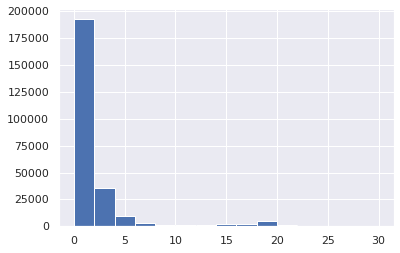

In [83]:
sns.set()
plt.hist(rides_df['Dist'], bins = 15)
plt.show()

In [84]:
np.sum(rides_df['Dist'])

540573.2090720178

In [61]:
my_list = [len(rides_df)]
growth = 1.15
x = len(rides_df)
for i in range(0,12):
    n = round(x*1.15,0)
    x = n
    my_list.append(n)

In [87]:
dist_rides = []

for rides in my_list:
    distance = round(np.sum(np.random.exponential(2.145667,int(rides))),2)
    dist_rides.append(distance)

In [88]:
dist_rides

[549515.03,
 633651.88,
 729273.68,
 837943.76,
 964828.48,
 1106771.04,
 1275597.96,
 1468764.96,
 1687317.8,
 1934334.82,
 2230716.31,
 2561805.99,
 2947179.01]

In [89]:
#total co2
per_mile = 404 #grams
miles = []
for dist in dist_rides:
    n = round(dist*per_mile,2)
    miles.append(n)

np.sum(miles)

7646791090.88

In [90]:
7646791090.88/1000000

7646.79109088